# Gradient Descent

## Goals

To gain an intuition about gradient descent methods by visualizing them in some simple 2D surfaces.

## Surfaces

In [1]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

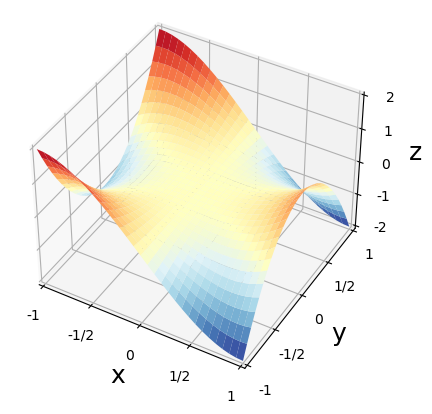

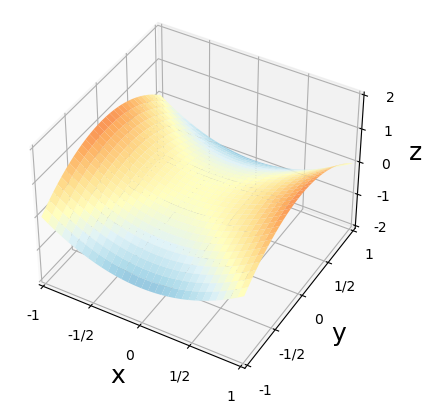

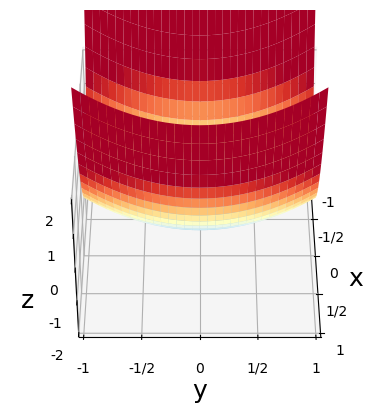

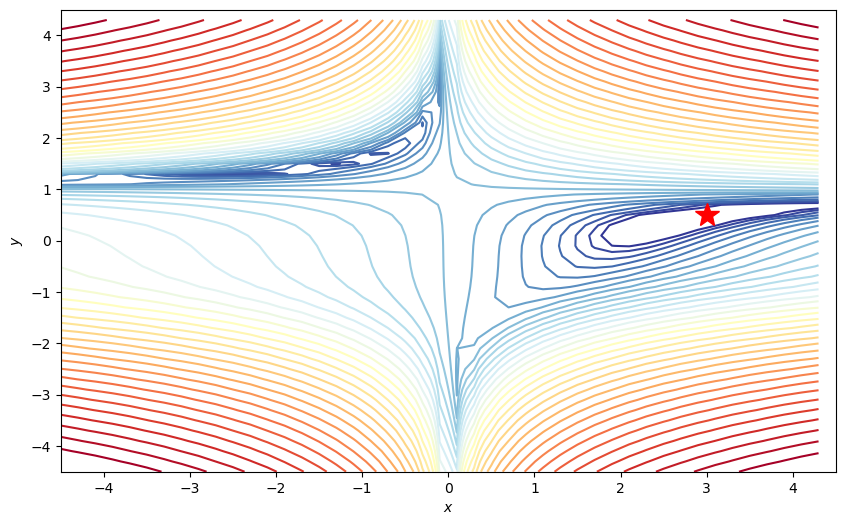

In [2]:
#DEFINE SURFACES WE WILL WORK WITH

#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

#Define saddle surface

def saddle_surface(x,y,a=1,b=1):
    return a*x**2-b*y**2

def grad_saddle_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= a*x
    grad_y= -1*b*y
    return [grad_x,grad_y]


# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]


def beales_function(x,y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax
    
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
fig2,ax2=plot_surface(x,y,saddle_surface(x,y))
fig3,ax3=plot_surface(x,y,minima_surface(x,y,5),0)

#Contour plot of Beale's Function

fig4,ax4 =contour_beales_function()
plt.show()

## Gradient descent with and without momentum

We start by considering a simple gradient descent method. In this method, we will take steps in the direction of the local gradient. Given some parameters $\theta$, we adjust the parameters at each iteration so that

$ \theta_{t+1} = \theta_t - \eta_t \nabla_\theta E(\theta)$ 

In [3]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov. 

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

## Methods

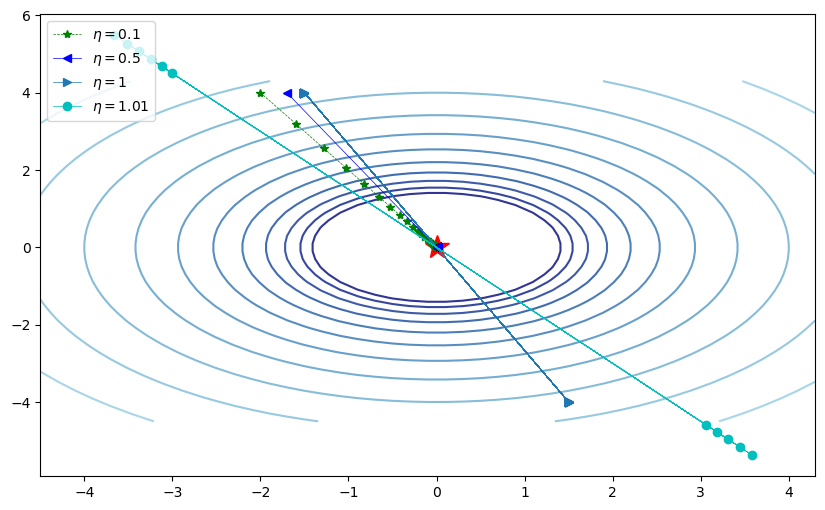

In [4]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_minima_surface,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_minima_surface,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_minima_surface,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')